# 보스턴 주택 가격 예측
## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
print(tf.__version__)

2.9.2


### 랜덤 시드 고정

In [2]:
SEED = 12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("시드 고정:", SEED)

시드 고정: 12


## dataset 가져오기

In [5]:
from sklearn import datasets
housing = datasets.load_boston()
X_data = housing.data
y_data = housing.target
print(X_data.shape, y_data.shape)

(506, 13) (506,)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## 데이터 전처리

### min max scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_data_scaled = scaler.fit_transform(X_data)

X_data_scaled[0]

array([0.        , 0.18      , 0.06781525, 0.        , 0.31481481,
       0.57750527, 0.64160659, 0.26920314, 0.        , 0.20801527,
       0.28723404, 1.        , 0.08967991])

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=True, random_state=SEED)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


### scaler의 경우 train set과 test set 분리 후에 사용해야 함
- scaler가 train에는 fit transform을 사용하여 경향성을 학습함
- test에는 fit을 사용 -> test set의 정보를 미리 알아서는 안 되기 때문

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 모델 정의

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
def build_model(num_input=1):
  model = Sequential()
  model.add(Dense(128, activation='relu', input_dim=num_input))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='relu'))

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  
  return model

model = build_model(num_input=13)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


## 학습 using mini batch

In [11]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
13/13 - 1s - loss: 90.2208 - mae: 7.0756 - 1s/epoch - 95ms/step
Epoch 2/100
13/13 - 0s - loss: 64.1642 - mae: 5.7309 - 31ms/epoch - 2ms/step
Epoch 3/100
13/13 - 0s - loss: 64.0255 - mae: 5.6375 - 31ms/epoch - 2ms/step
Epoch 4/100
13/13 - 0s - loss: 59.8935 - mae: 5.7237 - 30ms/epoch - 2ms/step
Epoch 5/100
13/13 - 0s - loss: 56.3740 - mae: 5.4424 - 37ms/epoch - 3ms/step
Epoch 6/100
13/13 - 0s - loss: 64.8597 - mae: 5.7255 - 33ms/epoch - 3ms/step
Epoch 7/100
13/13 - 0s - loss: 55.9069 - mae: 5.6685 - 35ms/epoch - 3ms/step
Epoch 8/100
13/13 - 0s - loss: 59.0239 - mae: 5.4474 - 30ms/epoch - 2ms/step
Epoch 9/100
13/13 - 0s - loss: 53.3005 - mae: 5.2688 - 34ms/epoch - 3ms/step
Epoch 10/100
13/13 - 0s - loss: 46.8453 - mae: 4.8642 - 29ms/epoch - 2ms/step
Epoch 11/100
13/13 - 0s - loss: 49.0438 - mae: 5.0323 - 33ms/epoch - 3ms/step
Epoch 12/100
13/13 - 0s - loss: 46.4895 - mae: 4.8189 - 35ms/epoch - 3ms/step
Epoch 13/100
13/13 - 0s - loss: 58.3394 - mae: 5.6123 - 43ms/epoch - 3ms/s

## 모델 평가
- 검증시 train보다 loss 크게 나오므로 overfitting 예상

In [12]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 4ms/step - loss: 21.7316 - mae: 3.3472


[21.731616973876953, 3.347184658050537]

## 교차검증 사용

In [13]:
model = build_model(num_input=13)
history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2, verbose=2)

Epoch 1/200
11/11 - 1s - loss: 1118.9365 - mae: 25.0100 - val_loss: 177.1982 - val_mae: 10.7320 - 914ms/epoch - 83ms/step
Epoch 2/200
11/11 - 0s - loss: 156.5112 - mae: 9.6945 - val_loss: 85.0545 - val_mae: 6.0418 - 54ms/epoch - 5ms/step
Epoch 3/200
11/11 - 0s - loss: 80.2472 - mae: 6.4040 - val_loss: 62.6597 - val_mae: 6.0578 - 53ms/epoch - 5ms/step
Epoch 4/200
11/11 - 0s - loss: 74.6217 - mae: 6.8035 - val_loss: 59.9806 - val_mae: 5.6697 - 68ms/epoch - 6ms/step
Epoch 5/200
11/11 - 0s - loss: 69.3999 - mae: 5.9353 - val_loss: 60.3749 - val_mae: 5.5061 - 61ms/epoch - 6ms/step
Epoch 6/200
11/11 - 0s - loss: 68.6472 - mae: 5.8788 - val_loss: 58.3637 - val_mae: 5.7434 - 70ms/epoch - 6ms/step
Epoch 7/200
11/11 - 0s - loss: 71.3793 - mae: 6.5040 - val_loss: 59.4303 - val_mae: 5.6536 - 52ms/epoch - 5ms/step
Epoch 8/200
11/11 - 0s - loss: 68.1184 - mae: 5.8173 - val_loss: 59.5605 - val_mae: 5.6536 - 59ms/epoch - 5ms/step
Epoch 9/200
11/11 - 0s - loss: 66.7407 - mae: 5.9184 - val_loss: 59.6028

## 시각화
- epoch 10까지 매우 빠르게 학습 진행
- 이후 학습 속도 감소

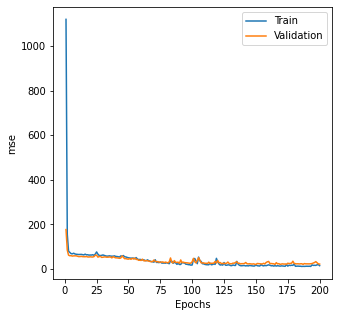

In [16]:
import matplotlib.pyplot as plt
def plot_loss_curve(total_epoch=10, start=1):
  plt.figure(figsize=(5, 5))
  plt.plot(range(start, total_epoch + 1), history.history['loss'][start-1:total_epoch], label='Train')
  plt.plot(range(start, total_epoch + 1), history.history['val_loss'][start-1:total_epoch], label='Validation')

  plt.xlabel('Epochs')
  plt.ylabel('mse')
  plt.legend()
  plt.show()

plot_loss_curve(total_epoch=200, start=1)

### 20 epoch 이후 그래프 확인

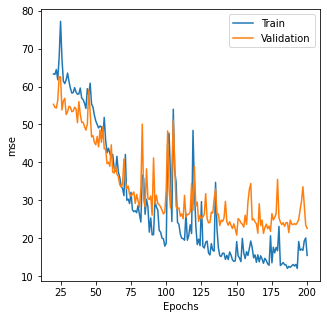

In [17]:
plot_loss_curve(total_epoch=200, start=20)

## scaled data 사용

In [19]:
model = build_model(num_input=13)
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=200, validation_split=0.2, verbose=2)

Epoch 1/200
11/11 - 2s - loss: 585.0315 - mae: 22.3777 - val_loss: 539.0397 - val_mae: 21.1872 - 2s/epoch - 210ms/step
Epoch 2/200
11/11 - 0s - loss: 555.4110 - mae: 21.6635 - val_loss: 491.9402 - val_mae: 19.9801 - 75ms/epoch - 7ms/step
Epoch 3/200
11/11 - 0s - loss: 478.7756 - mae: 19.7576 - val_loss: 379.1222 - val_mae: 16.7188 - 90ms/epoch - 8ms/step
Epoch 4/200
11/11 - 0s - loss: 325.7545 - mae: 15.3115 - val_loss: 203.0222 - val_mae: 11.0336 - 70ms/epoch - 6ms/step
Epoch 5/200
11/11 - 0s - loss: 162.7984 - mae: 10.1942 - val_loss: 151.8599 - val_mae: 9.6198 - 86ms/epoch - 8ms/step
Epoch 6/200
11/11 - 0s - loss: 144.1623 - mae: 9.5835 - val_loss: 124.2107 - val_mae: 8.6529 - 85ms/epoch - 8ms/step
Epoch 7/200
11/11 - 0s - loss: 112.2185 - mae: 8.2823 - val_loss: 100.5926 - val_mae: 7.5376 - 73ms/epoch - 7ms/step
Epoch 8/200
11/11 - 0s - loss: 95.2753 - mae: 7.4119 - val_loss: 86.0452 - val_mae: 6.8765 - 91ms/epoch - 8ms/step
Epoch 9/200
11/11 - 0s - loss: 82.1592 - mae: 6.7533 - va

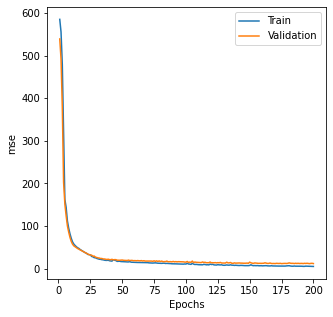

In [20]:
plot_loss_curve(total_epoch=200, start=1)

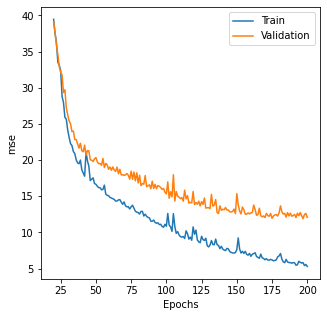

In [21]:
plot_loss_curve(total_epoch=200, start=20)